In [586]:
import anndata as ad
import pandas as pd
import numpy as np
import scanpy as sc
import decoupler as dc
import os

In [587]:
def validate_input_arguments (arguments_list):
    if arguments_list["out_path"] is None:
        print("Please provide an output path")
    elif arguments_list["out_path"][-1] != "/":
        arguments_list["out_path"] = arguments_list["out_path"] + "/"

    if arguments_list["celltype"] is None:
        print("Please provide the name of the metadata field containing cell type annotations")

    if arguments_list["condition"] is None:
        print("Please provide the name of the metadata field containing condition annotations")

    if arguments_list["organism"] is None:
        arguments_list["organism"] = "human"

    if arguments_list["comparison_list"] is None:
        arguments_list["comparison_list"] = np.nan

    if arguments_list["logfc"] is None:
        arguments_list["logfc"] = 0.0

    if arguments_list ["pval"] is None:
        arguments_list["pval"] = 0.05

    if arguments_list["reg"] is None:
        arguments_list["reg"] = load_dorothea_regulon(arguments_list["organism"])

    elif isinstance(arguments_list["reg"], str):
        arguments_list["reg"] = pd.read_csv(arguments_list["reg"], index_col=0)
        arguments_list["reg"] = pd.DataFrame.rename(arguments_list["reg"], columns={"source" : "tf"})

    if not "tf" in arguments_list["reg"] and "target" in arguments_list["reg"] and "weight"in arguments_list["reg"]:
        raise Exception("Not all necessary columns found in regulon table! Please make sure that the regulon has the columns source, target and weight!")
    
 
   
    return(arguments_list)



In [588]:
#anndataobject = ad.read_h5ad("LR2TF_test_run/anndata_object.h5ad")   
#gene_ids = anndataobject.var.index.values
#cluster line even necessary if not returned?
#clusters = anndataobject.obs[celltype].cat.categories
#obs = anndataobject[:,gene_ids].X.toarray()
#sub_object = pd.DataFrame(obs,columns=gene_ids,index= anndataobject.obs["new_annotation"])
#average_obs = sub_object.groupby(level=0, observed=False).mean()
#average_obs.T.to_csv("average.csv")
#sub_object.

In [589]:
def AverageExpression(anndataobject, celltype = None, outpath = None):
    gene_ids = anndataobject.var.index.values
    #cluster line even necessary if not returned?
    #clusters = anndataobject.obs[celltype].cat.categories
    obs = anndataobject[:,gene_ids].X.toarray()
    sub_object = pd.DataFrame(obs,columns=gene_ids,index= anndataobject.obs[celltype])
    sub_object = sub_object.groupby(level=0, observed=False).mean()
    sub_object.T.to_csv(outpath + "average_gene_expression_by_cluster.csv")

    return sub_object.T


In [590]:
#not per cluster but cluster and pval etc need to be added to csv (check against specific marker csv from lr2tf test run in R)

def get_significant_tfs_single(anndataobject, celltype, condition, out_path, pval, logfc):
    
    #does not work if condition is None
    single_result_path = out_path + condition 
    if not os.path.isdir(single_result_path):
        os.mkdir(single_result_path)
    
    #sc.pp.scale(anndataobject)
    #or sc.pp.normalize_total(anndataobject)
    # sc.pp.log1p(anndata_object) 
    
    #for later
    #number_of_clusters = len(anndataobject.uns["tf_annotation"]) 
    
    #anndataobject_markers= dc.get_acts(anndataobject)

    anndataobject.uns["t-test"] = sc.tl.rank_genes_groups(anndataobject, groupby= celltype, reference="rest", method="t-test_overestim_var")
    anndataobject.uns["wilcoxon"] = sc.tl.rank_genes_groups(anndataobject, groupby= celltype, reference="rest", method="wilcoxon")
    
     #FindAllMarkers(seuratobject, only.pos = TRUE, min.pct = 0, logfc.threshold = 0, verbose = FALSE)

    result = anndataobject.uns['rank_genes_groups']
    groups = result['names'].dtype.names
    anndataobject_markers = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names','logfoldchanges','pvals','pvals_adj']})
    anndataobject_markers.to_csv((single_result_path + "/all_specificmarker_" + condition + "_py.csv"), index=0)
    #anndataobject_markers = sc.get.rank_genes_groups_df(anndataobject, group = , key = "extract_later")
    #anndataobject_markers.write_csvs((single_result_path + "/all_specificmarker_" + condition + ".csv"))
    
    #pd.DataFrame.from_dict(anndataobject.uns["rank_genes_groups"], orient="index")
    #to.csv((single_result_path + "/all_specificmarker_" + condition + ".csv"))


    print(anndataobject.uns["rank_genes_groups"])
    return anndataobject

In [591]:
#test if subsetting object and using sc.pp.calculate_qc_metrics yields same results (yes it does)

#anndataobject = ad.read_h5ad("LR2TF_test_run/anndata_object.h5ad")
#anndataobject.obs["new_annotation"]
#neural = anndataobject[anndataobject.obs.new_annotation == "Neural"]
#megakaryocyte = anndataobject[anndataobject.obs.new_annotation == "Neural"]
#msc = anndataobject[anndataobject.obs.new_annotation == "Neural"]
#fibroblast = anndataobject[anndataobject.obs.new_annotation == "Neural"]
#myeloid = anndataobject[anndataobject.obs.new_annotation == "Neural"]

#test_neural = sc.pp.calculate_qc_metrics(neural, inplace=True)
#neural.var.to_csv("test_neural")

In [592]:
#ignore extra tfs from decoupler while writing script 

def tf_activity_analysis (anndataobject, tf_activities = None, arguments_list = None):
    
    if (isinstance(anndataobject, str)):
        anndataobject = ad.read_h5ad(anndataobject)

    arguments_list = validate_input_arguments(arguments_list)

    if not os.path.isdir(arguments_list["out_path"]):
        os.mkdir(arguments_list["out_path"])
        tf_path = arguments_list["out_path"] + "TF_results/"
        os.mkdir(tf_path)
    else:
        tf_path = arguments_list["out_path"] + "TF_results/"

    #skipped tf activities part. ignore extra tf data from decoupler?

    anndataobject.obs["condition"] = arguments_list["condition"] 
    anndataobject.obs["cell_type"] = arguments_list["celltype"]
    anndataobject.obs["comparison_list"] = arguments_list["comparison_list"]

    if not np.isnan(arguments_list["comparison_list"]):
        if len(arguments_list["comparison_list"]) > 0 & len(anndataobject.obs["comparison_list"]) < 2:
            arguments_list["comparison_list"] <- np.nan
            print("Only one condition was found in the data, although a list of comparisons was provided. The analyses are performed only for the present condition!")

    #code for single condition  analysis

    if np.isnan(arguments_list["comparison_list"]):
        anndataobject.uns["tf_annotation"] = pd.DataFrame({"result_list" : [],
        "gene_expression_list" : [],
        "CTR_cluster_list" : [],
        "intranet_cluster_list" : []})

    #anndataobject_list = split by condition, skipped for now
    sub_object = anndataobject

    #NOT THE SAME RESULTS AS R AVERAGE EXPRESSION
    sub_object.uns["Average_Expression"] = AverageExpression(sub_object, celltype = arguments_list["celltype"], outpath= arguments_list["out_path"])

    #add name into parameters later 
    tf_activity_scores = get_significant_tfs_single(sub_object, arguments_list["celltype"], arguments_list["condition"], tf_path, pval = arguments_list["pval"], logfc = arguments_list["logfc"])
    #result_list["name"] = tf_activity_scores
    #gene_expression_list[name + "_average_expression"] = sub_object.layers["cell_type"]
    #if (arguments_list["organism"] == "human"):
        #CTR_cluster_list["name"] = generate_CrossTalkeR_input(tf_activity_scores[

    return(sub_object)

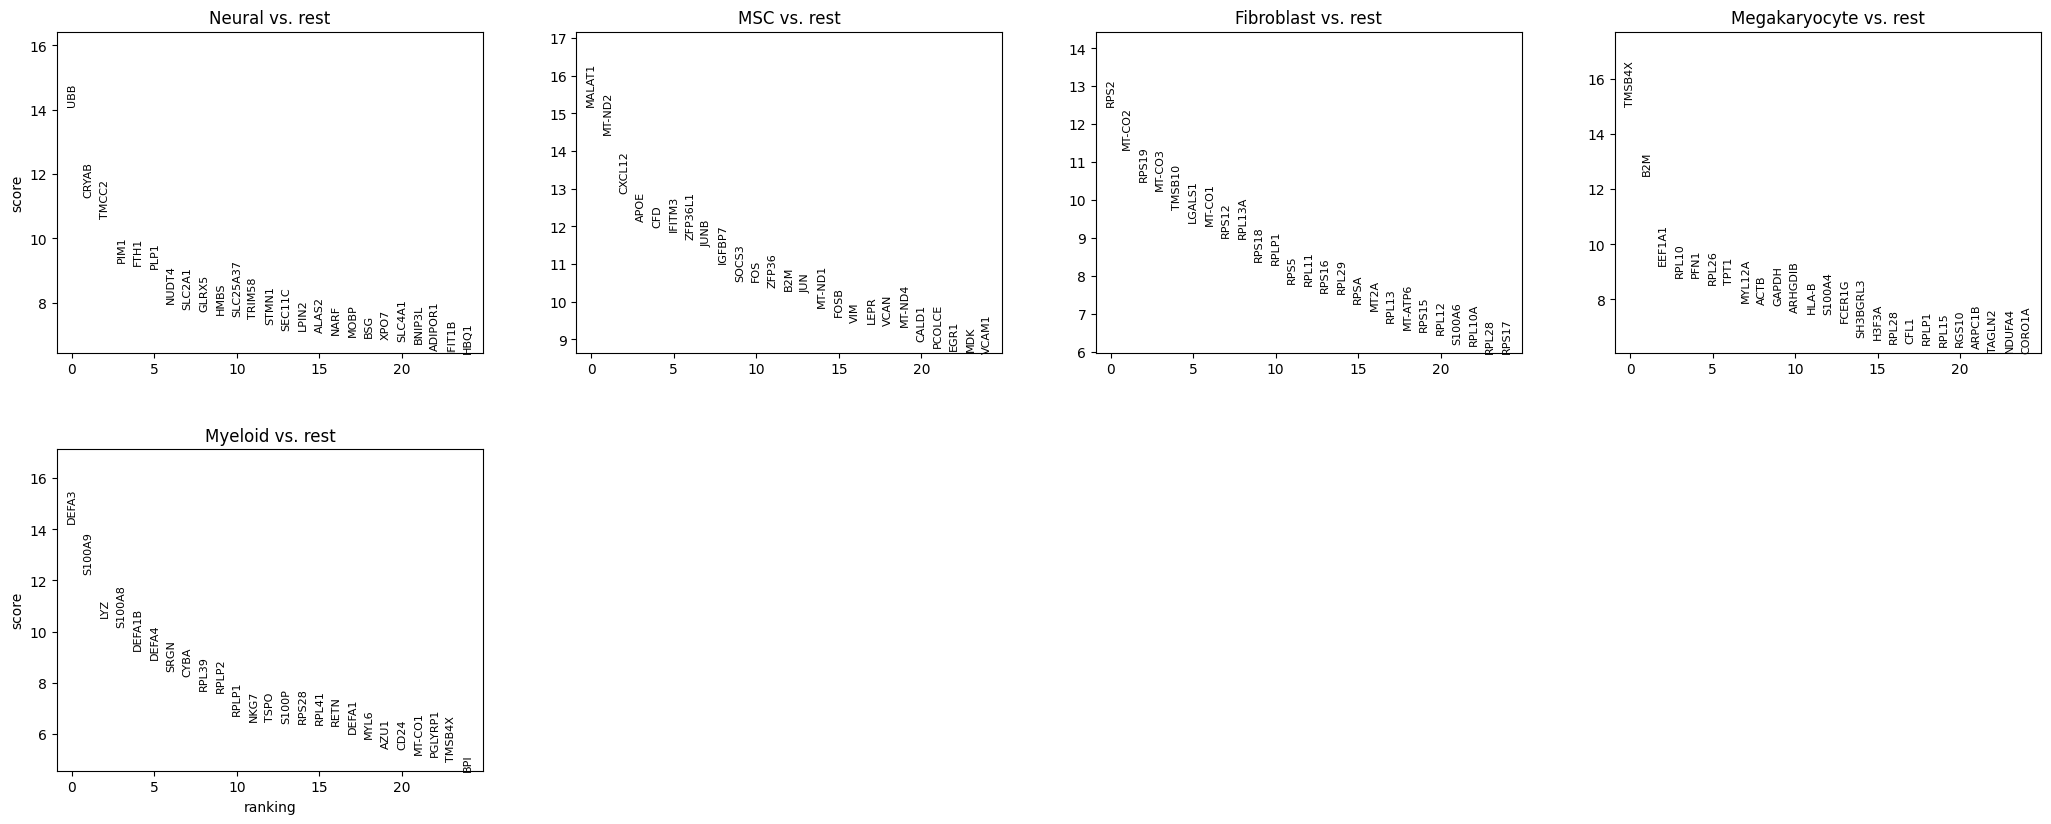

{'params': {'groupby': 'new_annotation', 'reference': 'rest', 'method': 't-test', 'use_raw': False, 'layer': None, 'corr_method': 'benjamini-hochberg'}, 'names': rec.array([('UBB', 'MALAT1', 'RPS2', 'TMSB4X', 'DEFA3'),
           ('CRYAB', 'MT-ND2', 'MT-CO2', 'B2M', 'S100A9'),
           ('TMCC2', 'CXCL12', 'RPS19', 'EEF1A1', 'LYZ'), ...,
           ('MT-CO2', 'PLP1', 'HLA-A', 'PLP1', 'CRYAB'),
           ('MT-CO1', 'UBB', 'CRYAB', 'CXCL12', 'FBXO7'),
           ('TMSB10', 'STMN1', 'TMCC2', 'CRYAB', 'LGALS1')],
          dtype=[('Neural', 'O'), ('MSC', 'O'), ('Fibroblast', 'O'), ('Megakaryocyte', 'O'), ('Myeloid', 'O')]), 'scores': rec.array([( 14.126273, 15.200885,  12.484958,  15.034774,  14.22307 ),
           ( 11.293869, 14.445743,  11.346714,  12.526433,  12.231516),
           ( 10.631797, 12.871109,  10.503536,   9.253549,  10.559634),
           ...,
           (-16.675573, -8.353011,  -8.820513,  -8.297192, -10.500448),
           (-18.717775, -8.404442,  -9.006083,  -9.13903

In [593]:
sub_object = tf_activity_analysis(anndataobject= "LR2TF_test_run/anndata_object.h5ad", arguments_list= {"out_path" : "folder", "celltype" : "new_annotation", "condition" : "control", "organism" : None, "comparison_list" : None, "logfc" : None, "pval" : None, "reg" : "human_dorothea_reg.csv"})

In [594]:
anndataobject[:,"ISG15"].X.todense().sum()
sub_object.uns["Average_Expression"]

new_annotation,Neural,MSC,Fibroblast,Megakaryocyte,Myeloid
FO538757.2,0.045191,0.365838,0.043312,0.308894,0.112166
RP11-206L10.9,0.000000,0.020690,0.034930,0.000000,0.000000
SAMD11,0.000000,0.000000,0.000000,0.000000,0.000000
NOC2L,0.000000,0.078729,0.123824,0.051798,0.053173
HES4,0.000000,0.252494,0.000000,0.074781,0.000000
...,...,...,...,...,...
SMYD5,0.000000,0.000000,0.000000,0.000000,0.000000
CCDC85C,0.000000,0.000000,0.000000,0.000000,0.000000
CPNE2,0.000000,0.000000,0.000000,0.000000,0.000000
TMEM206,0.000000,0.000000,0.000000,0.000000,0.000000
